In [4]:
import numpy as np
import os
import numpy as np
import uncertainties as u
from uncertainties import ufloat
from uncertainties.umath import sqrt
from uncertainties.umath import __all__
from uncertainties.umath import *
import uncertainties.unumpy as unp
import scipy.constants
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas # pip install Jinja2
import pint # pip install pint OR conda install pint
import warnings

warnings.simplefilter("ignore")

units = pint.UnitRegistry(autoconvert_offset_to_baseunit = True)
units.default_format = '~'
units.setup_matplotlib(True)

ulog = u.wrap(np.log)
upower = u.wrap(np.power)
umultiply = u.wrap(np.multiply)
udivide = u.wrap(np.divide)
umean = u.wrap(np.mean)

cm = 1/2.54 # For matplotlib figure sizes

In [36]:
def extr_values(np_arr):
    return unp.nominal_values(np_arr)

def extr_sig(np_arr):
    return unp.std_devs(np_arr)

# u_x: np.array(u.ufloat) * ureq.unit{optional}
# u_y: np.array(u.ufloat) * ureq.unit{optional}
def graph_1(u_x, u_y,
    xlabel='xlabel', ylabel='ylabel', legloc='upper left',
    do_linfit=False,
    y_axis_log=False, x_axis_log=False,
    figsize=(12*cm, 12*cm), safeas='graph1.png'
):
    fig, ax = plt.subplots(1,1,figsize=figsize)

    has_x_units_inside = False
    if hasattr(u_x[0], 'units') and hasattr(u_x[0], 'magnitude'):
        has_x_units_inside = True
        x_unit_inside = u_x[0].units
        u_x = np.array([x.magnitude for x in u_x])
    
    has_y_units_inside = False
    if hasattr(u_y[0], 'units') and hasattr(u_y[0], 'magnitude'):
        has_y_units_inside = True
        y_unit_inside = u_y[0].units
        u_y = np.array([y.magnitude for y in u_y])

    
    # Extract values and uncertainties from uncertainty arrays
    X, Y, sig_Y = unp.nominal_values(u_x), unp.nominal_values(u_y), unp.std_devs(u_y)
    
    if y_axis_log:
        ax.set_yscale("log")
    if x_axis_log:
        ax.set_xscale("log")
    
    if do_linfit:
        fit_result = scipy.stats.linregress(X, Y)
        u_Slope = u.ufloat(fit_result.slope, fit_result.stderr)
        u_Intercept = u.ufloat(fit_result.intercept, fit_result.intercept_stderr)
        #slope, intercept, rvalue, pvalue, sevalue, inteerr
        print("slope: ", fit_result.slope)
        print("slope_err:", fit_result.stderr)
        print("intercept: ", fit_result.intercept)
        x_axis_spaced = np.linspace(np.min(X), np.max(X), 100)
        ax.plot(x_axis_spaced, fit_result.slope*x_axis_spaced + fit_result.intercept,
            'b--', label=r'm{}+b = ({:.1u}){} + ({:.1uP})'.format(xlabel, u_Slope, xlabel, u_Intercept))
    
    #ax.plot(x_axis_spaced, result.slope*x_axis_spaced + result.intercept, 'r--', label='label')
    ax.errorbar(X, Y, yerr=sig_Y, linestyle='-', color='red', capsize=3, label='meas. tuples ({}, {}, {})'.format(xlabel, ylabel, r'$\sigma$'))

    # Pretty print units
    units.setup_matplotlib(True)
    if hasattr(u_x, 'units'):
        ax.xaxis.set_units(u_x.units)
        ax.set_xlabel("{} ({:~P})".format(xlabel, u_x.units))
    elif has_x_units_inside:
        ax.xaxis.set_units(x_unit_inside)
        ax.set_xlabel("{} ({:~P})".format(xlabel, x_unit_inside))
    else:
        ax.set_xlabel(xlabel)
    if hasattr(u_y, 'units'):
        ax.yaxis.set_units(u_y.units)
        ax.set_ylabel("{} ({:~P})".format(ylabel, u_y.units))
    elif has_y_units_inside:
        ax.yaxis.set_units(y_unit_inside)
        ax.set_ylabel("{} ({:~P})".format(ylabel, y_unit_inside))
    else:
        ax.set_ylabel(ylabel)
    
    ax.legend(loc=legloc)
    plt.tight_layout()
    plt.savefig(safeas, dpi=500)
    plt.show()

    if do_linfit:
        return u_Slope, u_Intercept

In [37]:
# Area of a Circle
def CircleArea(radius):
    return np.pi * (radius**2)
uCircleArea = u.wrap(CircleArea)

## Given
$l_{2} = (70.0\pm0.2)~\mathrm{mm}, R_{2} = (10.20\pm0.01)~\mathrm{m\Omega}, D = (5.00\pm0.02)~\mathrm{mm}, S=(19.63\pm0.16)~\mathrm{mm^2}, A_{Nickel-Kupfer} = (20.40\pm0.05)~\mathrm{\mu V~K^{-1}}$

In [38]:
u_l2 = u.ufloat(70.0, 0.2) * units.mm
u_R2 = u.ufloat(10.2, 0.01) * units.milliohm
u_D = u.ufloat(5.00, 0.02) * units.mm
u_S = uCircleArea(u_D/2.0)
u_A__nicker_kupfer = u.ufloat(20.4, 0.05) * units.microvolt / units.degree_Kelvin

# Measurements

In [39]:
# TODO WHAT IS THE UNCERTAINTY OF THE EFFECTIVE HEATING CURRENT I, I2?
I_unc = 99.99
I_meas_unit = units.mA

# EFFEKTIVE HEIZSTRÖME [1st I, 2nd I, 3rd I]
I_meas = [150, 200, 250]
u_I = np.array([u.ufloat(I, I_unc) * I_meas_unit for I in I_meas])

# TODO WHAT IS THE UNCERTAINTY OF THE HEATING VOLTAGE
V_unc = 99.99

# TODO Time uncertainty for measurement of I2
t_unc = 5 * units.s

In [40]:
# Measurements [ 1st, 2nd, 3rd ]
a_I2_meas_unit = units.mA
a_t_meas_unit = units.min
V_meas_unit = units.V

# TODO HEIZSPANNUNGEN
a_V_meas = [999., 888., 777.]
au_V = np.array([u.ufloat(V, V_unc) * V_meas_unit for V in a_V_meas])

a_I2_meas = [
    np.array([99., 99., 99., 99., 99., 99., 99., 99.]),
    np.array([99., 99., 99., 99., 99., 99., 99., 99.]),
    np.array([99., 99., 99., 99., 99., 99., 99., 99.]),
]
a_t_meas = [
    np.array([5., 10., 15., 20., 25., 30., 35., 40.]),
    np.array([5., 10., 15., 20., 25., 30., 35., 40.]),
    np.array([5., 10., 15., 20., 25., 30., 35., 40.]),
]
au_I2 = [ np.array([u.ufloat(I2, I_unc) * a_I2_meas_unit for I2 in I2_arr]) for I2_arr in a_I2_meas ]
au_t = [ np.array([u.ufloat(t, t_unc.to(a_t_meas_unit).magnitude) * a_t_meas_unit for t in t_arr]) for t_arr in a_t_meas ]

# Plot $I_{2}(t)$ and show at asymptote to determine $I_{2}^{EQ}$

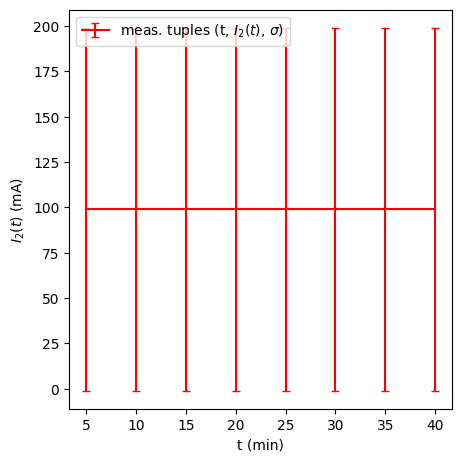

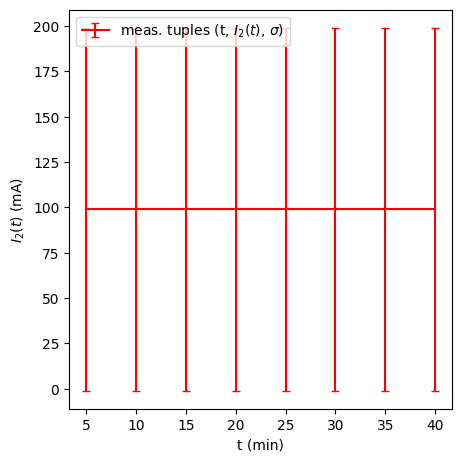

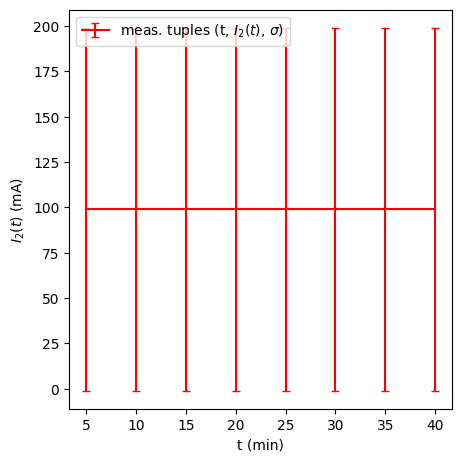

In [45]:
for i in range(0, len(a_I2_meas)):
    u_X = np.array([t.to_compact() for t in au_t[i]])
    u_Y = np.array([I2.to_compact() for I2 in au_I2[i]])
    graph_1(
        u_X, u_Y,
        xlabel='t',
        ylabel=r'$I_{2}(t)$',
        figsize=(12*cm, 12*cm),
        safeas='graph_I2_of_t_{}.png'.format(i),
    )

In [54]:
# Equilibrium I2 values
# TODO INSERT THEM HERE
I2_EQ_UNIT = units.mA
a_I2_EQ_meas = np.array([ 999.99, 999.99, 999.99 ])
au_I2_EQ = np.array([u.ufloat(I2_EQ, 9999999999.99) * I2_EQ_UNIT for I2_EQ in a_I2_EQ_meas])

au_I2_EQ

array([<Quantity((0.0+/-1.0)e+10, 'milliampere')>,
       <Quantity((0.0+/-1.0)e+10, 'milliampere')>,
       <Quantity((0.0+/-1.0)e+10, 'milliampere')>], dtype=object)

# Now calculate the values of $\Delta T$ betw. C and D
### Eq. 35:
$\Delta T = \frac{I_{2}R_{2}}{A_{NickelCopper}}$

In [66]:
def CalcDeltaT_BetwCandD(u_I2_EQ):
    return (u_I2_EQ*u_R2)/u_A__nicker_kupfer
uCalcDeltaT_BetwCandD = u.wrap(CalcDeltaT_BetwCandD)

In [67]:
au_DeltaT = np.array([uCalcDeltaT_BetwCandD(I2_EQ) for I2_EQ in au_I2_EQ])

au_DeltaT

array([<Quantity((0+/-5)e+09, 'kelvin * milliampere * milliohm / microvolt')>,
       <Quantity((0+/-5)e+09, 'kelvin * milliampere * milliohm / microvolt')>,
       <Quantity((0+/-5)e+09, 'kelvin * milliampere * milliohm / microvolt')>],
      dtype=object)

# Now calculate the values $\lambda_{W}$
### With Eq. 36:
$\lambda_{W} = \frac{ IVA_{nc}l_{2} }{ SI_{2}R_{2} }$

In [68]:
def CalcLambdaW(I, V, I2):
    return (I*V*u_A__nicker_kupfer*u_l2)/(u_S*I2*u_R2)
uCalcLambdaW = u.wrap(CalcLambdaW)

In [69]:
au_LambdaW = np.array([uCalcLambdaW(u_I[i], au_V[i], au_I2_EQ[i]).to_base_units().to_compact() for i in range(0, len(u_I))])

au_LambdaW

array([<Quantity((0.0+/-1.1)e+10, 'kilogram * meter / kelvin / second ** 3')>,
       <Quantity((0.0+/-1.3)e+10, 'kilogram * meter / kelvin / second ** 3')>,
       <Quantity((0.0+/-1.4)e+10, 'kilogram * meter / kelvin / second ** 3')>],
      dtype=object)

In [70]:
u_Mean_LambdaW = umean(au_LambdaW)

(0.0+/-7.2)e+09 kg·m/K/s³
(0.0+/-7.2)e+09\ \frac{\mathrm{kg} \cdot \mathrm{m}}{\left(\mathrm{K} \cdot \mathrm{s}^{3}\right)}


# Make a beautiful Summary of all the Data of task two

In [71]:
print("TABLE (I, V, I2, DeltaT, LambdaW):")
df_I_V_I2_dT_LambdaW = pandas.DataFrame({
    'I': u_I,
    'V': au_V,
    'I2': au_I2_EQ,
    'DeltaT': au_DeltaT,
    'LambdaW': au_LambdaW,
    })
df_I_V_I2_dT_LambdaW.transpose()
display(df_I_V_I2_dT_LambdaW)
print('\n\n\n')
print(df_I_V_I2_dT_LambdaW.to_latex(index=False))
print('\n\n\n')

TABLE (I, V, I2, DeltaT, LambdaW):


,I,V,I2,DeltaT,LambdaW
0,(1.5+/-1.0)e+02 mA,(1.00+/-0.10)e+03 V,(0.0+/-1.0)e+10 mA,(0+/-5)e+09 K * mA * mΩ / µV,(0.0+/-1.1)e+10 kg * m / K / s ** 3
1,(2.0+/-1.0)e+02 mA,(8.9+/-1.0)e+02 V,(0.0+/-1.0)e+10 mA,(0+/-5)e+09 K * mA * mΩ / µV,(0.0+/-1.3)e+10 kg * m / K / s ** 3
2,(2.5+/-1.0)e+02 mA,(7.8+/-1.0)e+02 V,(0.0+/-1.0)e+10 mA,(0+/-5)e+09 K * mA * mΩ / µV,(0.0+/-1.4)e+10 kg * m / K / s ** 3






\begin{tabular}{lllll}
\toprule
                 I &                   V &                 I2 &                       DeltaT &                             LambdaW \\
\midrule
(1.5+/-1.0)e+02 mA & (1.00+/-0.10)e+03 V & (0.0+/-1.0)e+10 mA & (0+/-5)e+09 K * mA * mΩ / µV & (0.0+/-1.1)e+10 kg * m / K / s ** 3 \\
(2.0+/-1.0)e+02 mA &   (8.9+/-1.0)e+02 V & (0.0+/-1.0)e+10 mA & (0+/-5)e+09 K * mA * mΩ / µV & (0.0+/-1.3)e+10 kg * m / K / s ** 3 \\
(2.5+/-1.0)e+02 mA &   (7.8+/-1.0)e+02 V & (0.0+/-1.0)e+10 mA & (0+/-5)e+09 K * mA * mΩ / µV & (0.0+/-1.4)e+10 kg * m / K / s ** 3 \\
\bottomrule
\end{tabular}







In [73]:
print('<LambdaW> = {:.2u~P}'.format(u_Mean_LambdaW))
print('<LambdaW> = {:.2u~L}'.format(u_Mean_LambdaW))

<LambdaW> = (0.0+/-7.2)e+09 kg·m/K/s³
<LambdaW> = (0.0+/-7.2)e+09\ \frac{\mathrm{kg} \cdot \mathrm{m}}{\left(\mathrm{K} \cdot \mathrm{s}^{3}\right)}


# DONE